# Modeling

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install keras-tuner
!pip install scikit-learn
!pip install tensorflow
!pip install seaborn

In [204]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
from datetime import timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from kerastuner.tuners import RandomSearch

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm import tqdm
import pprint
import ast

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

## Load the Data

In [28]:
# Read in Parquet File
df_final = pd.read_parquet('02_Clean_Data/df_final.parquet')

## Data Preparation

In [26]:
# Shuffle Rows of Data
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
# Drop Non Numerical Columns
df_final = df_final.drop(['ID', 'Date', 'Ticker',
                          'Stock Ticker'], axis=1)

In [8]:
# Scale the dataframe
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_final),
                         columns=df_final.columns)

In [9]:
# Create a list of dataframes that will be stacked and converted
# to a TensorFlow Tensor
df_list = []
for i in range(0, 29):
    try:
        price_col = 'Price-' + str(i)
        rate_col = 'rate-' + str(i)
        div_col = 'Dividends-' + str(i)
        cols_filter = ['Close', 'Call', 'Days to Expiration',
                    'strike', price_col, rate_col, div_col]
        temp = scaled_df[cols_filter]
        df_list.append(temp)
    except:
        pass

In [10]:
# Preview the first dataframe in the List
df_list[0].head()

,Close,Call,Days to Expiration,strike,Price-0,rate-0,Dividends-0
0,0.001727,0.0,0.366460,0.142474,0.314285,0.662162,0.118085
1,0.011006,1.0,0.062112,0.038410,0.057659,0.589681,0.042693
2,0.024426,0.0,0.282609,0.169272,0.239672,0.570639,0.200491
3,0.012671,0.0,0.341615,0.115677,0.173466,0.754914,0.273253
4,0.005867,1.0,0.456522,0.075480,0.080304,0.707617,0.270623


In [11]:
# assume each dataframe has the same number of columns
n_features = len(df_list[0].columns)

# convert the dataframes into numpy arrays
df_array_list = [df.to_numpy() for df in df_list]

# stack the numpy arrays along the new time step dimension
tensor_data = np.stack(df_array_list, axis=1)

# create a TensorFlow tensor from the numpy array
tensor = tf.convert_to_tensor(tensor_data, dtype=tf.float32)

# print the shape of the tensor
tensor.shape

2023-04-17 15:30:53.256254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 15:30:53.257164: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TensorShape([375342, 20, 7])

In [12]:
# Preview the First 5 Observations of the First Layer of the Tensor
pd.DataFrame(tensor[0][0:5])

,0,1,2,3,4,5,6
0,0.001727,0.0,0.36646,0.142474,0.314285,0.662162,0.118085
1,0.001727,0.0,0.36646,0.142474,0.314590,0.662162,0.118085
2,0.001727,0.0,0.36646,0.142474,0.314590,0.662162,0.118085
3,0.001727,0.0,0.36646,0.142474,0.320258,0.662162,0.118085
4,0.001727,0.0,0.36646,0.142474,0.331029,0.662162,0.118085


In [13]:
# Print the Number of Observations, Timesteps, and Input Dimension
observations = len(tensor)
timesteps = len(tensor[0])
input_dim = len(tensor[0][0])

print('Observations: %d' % (observations))
print('Timesteps: %d' % (timesteps))
print('Input Dimension: %d' % (input_dim))

Observations: 375342
Timesteps: 20
Input Dimension: 7


In [14]:
# Split the data into Training, Validation, and Test Sets
train_data = tensor[:int(0.98 * len(tensor))]
val_data = tensor[int(0.98 * len(tensor)):int(0.99 * len(tensor))]
test_data = tensor[int(0.99 * len(tensor)):]

## Model 1: Simple Recurrent Neural Network

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='03_Hyperparameter_Tuning/RNN_01_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('04_Models/RNN_01_best_model.h5')

Trial 10 Complete [00h 14m 30s]
val_loss: 3.95700565907949e-05

Best val_loss So Far: 2.721390592341777e-05
Total elapsed time: 02h 28m 34s
118/118 [==============================] - 0s 3ms/step - loss: 4.8133e-05
Test loss: 4.81331990158651e-05


In [16]:
# Load the best model
best_model = load_model('04_Models/RNN_01_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/RNN_01_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 3ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,215.629440,257.059998,41.430557,0.161171
2716,169.537384,185.600006,16.062622,0.086544
2434,118.331711,128.350006,10.018295,0.078054
1234,108.459419,114.000000,5.540581,0.048602
2795,99.133865,109.610001,10.476135,0.095576


In [17]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,1.045332,0.01,1.035332,103.533226
1462,0.541489,0.01,0.531489,53.148872
1315,0.871510,0.01,0.861510,86.150993
1571,-1.496570,0.01,1.506570,150.657028
1404,2.689227,0.01,2.679227,267.922729


In [18]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 2.61


In [19]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 7.05 %


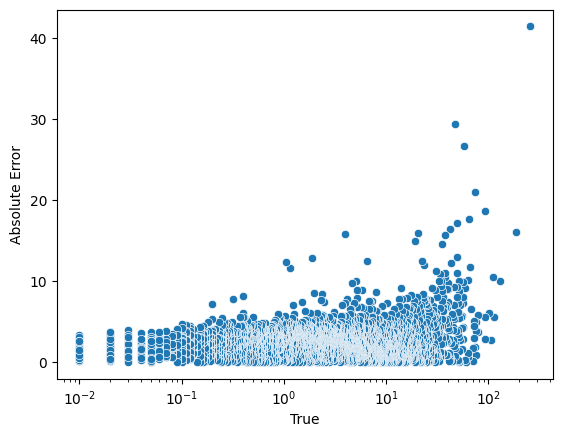

In [20]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

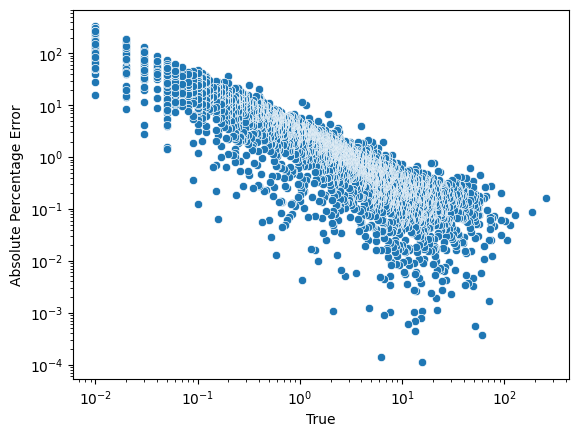

In [21]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 2: Standard LSTM

In [ ]:
# Define the LSTM Model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='03_Hyperparameter_Tuning/lstm_01_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the best model using the best hyperparameters
best_model = build_model(best_hyperparameters)

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('04_Models/lstm_01_best_model.h5')

Trial 10 Complete [00h 06m 02s]
val_loss: 3.0462577948734786e-05

Best val_loss So Far: 1.5203299274920331e-05
Total elapsed time: 00h 57m 21s
118/118 [==============================] - 0s 2ms/step - loss: 1.4763e-04
Test loss: 0.00014763057697564363


In [ ]:
# Load the best model
best_model = load_model('04_Models/lstm_01_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/lstm_01_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,132.050552,257.059998,125.009445,0.486305
2716,118.533623,185.600006,67.066383,0.361349
2434,103.421524,128.350006,24.928482,0.194223
1234,83.266464,114.000000,30.733536,0.269592
2795,97.705536,109.610001,11.904465,0.108607


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,-3.171011,0.01,3.181011,318.101105
1462,-3.047535,0.01,3.057535,305.753479
1315,-2.058816,0.01,2.068816,206.881592
1571,-4.791250,0.01,4.801250,480.125000
1404,-1.085169,0.01,1.095169,109.516922


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 2.97


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 7.47 %


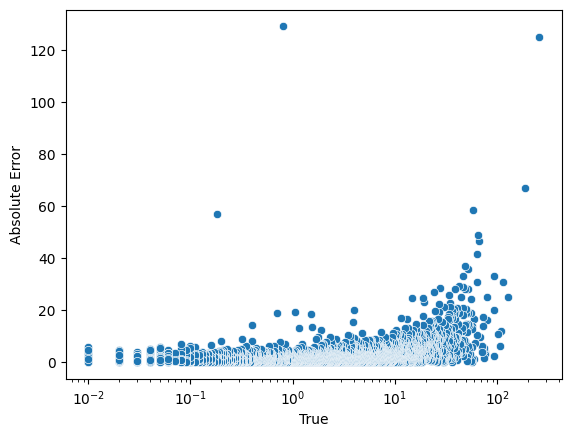

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

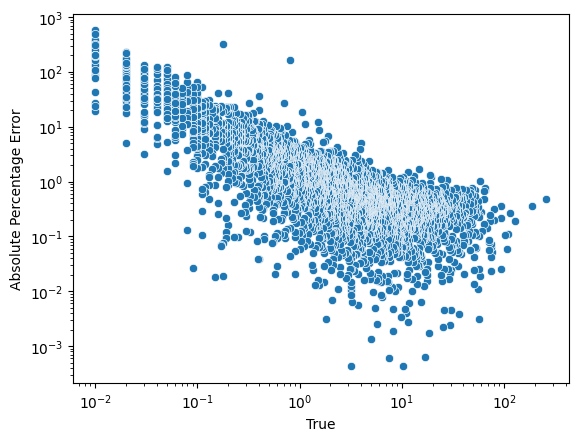

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 3: Stacked LSTM with 2 Layers

In [26]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), input_shape=(20, 6), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='03_Hyperparameter_Tuning/lstm_02_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('04_Models/lstm_02_best_model.h5')

Trial 10 Complete [00h 09m 28s]
val_loss: 2.461728945490904e-05

Best val_loss So Far: 2.3063260717511486e-05
Total elapsed time: 01h 34m 02s
INFO:tensorflow:Oracle triggered exit
118/118 [==============================] - 0s 3ms/step - loss: 2.5018e-05
Test loss: 2.501813469280023e-05


In [27]:
# Load the best model
best_model = load_model('04_Models/lstm_02_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/lstm_02_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 3ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,205.007111,257.059998,52.052887,0.202493
2716,159.579758,185.600006,26.020248,0.140195
2434,108.281464,128.350006,20.068542,0.156358
1234,98.396378,114.000000,15.603622,0.136874
2795,104.320709,109.610001,5.289291,0.048256


In [28]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,0.246208,0.01,0.236208,23.620766
1462,0.484692,0.01,0.474692,47.469151
1315,0.351418,0.01,0.341418,34.141792
1571,0.597400,0.01,0.587400,58.739960
1404,0.446314,0.01,0.436314,43.631390


In [29]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 1.41


In [30]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 2.37 %


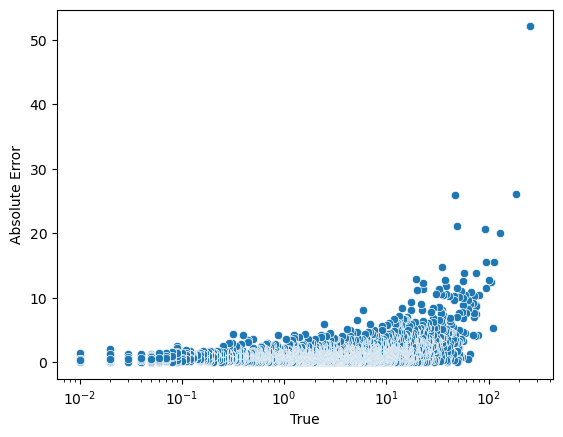

In [31]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

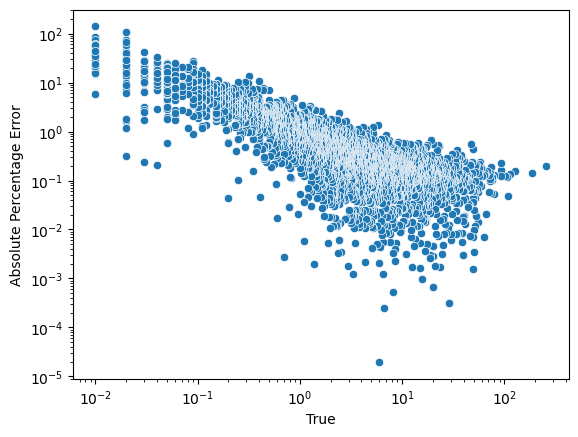

In [32]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 4: Stacked LSTM with 4 Layers

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), input_shape=(20, 6), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_3', min_value=32, max_value=256, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_4', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='03_Hyperparameter_Tuning/lstm_03_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('04_Models/lstm_03_best_model.h5')

Trial 10 Complete [00h 13m 40s]
val_loss: 3.5520142167418577e-05

Best val_loss So Far: 1.8961359576981824e-05
Total elapsed time: 02h 16m 35s
118/118 [==============================] - 0s 4ms/step - loss: 2.2120e-04
Test loss: 0.00022120367793831974


In [ ]:
# Load the best model
best_model = load_model('04_Models/lstm_03_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/lstm_03_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 2s 4ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,152.572800,257.059998,104.487198,0.406470
2716,113.491341,185.600006,72.108665,0.388517
2434,52.322712,128.350006,76.027298,0.592344
1234,61.067780,114.000000,52.932220,0.464318
2795,63.620178,109.610001,45.989822,0.419577


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,4.361207,0.01,4.351207,435.120728
1462,4.677115,0.01,4.667115,466.711487
1315,4.464442,0.01,4.454442,445.444214
1571,4.972969,0.01,4.962969,496.296906
1404,4.225525,0.01,4.215525,421.552490


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 4.71


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 17.58 %


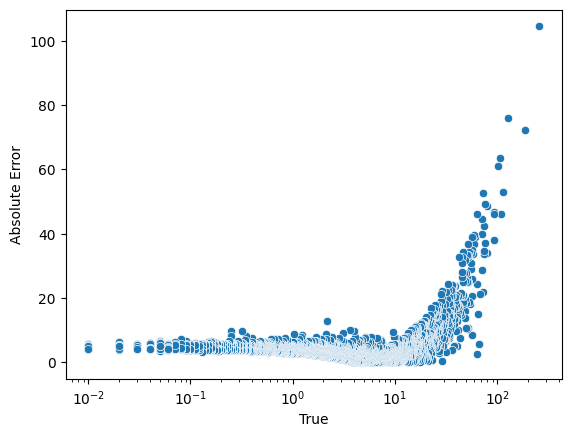

In [35]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

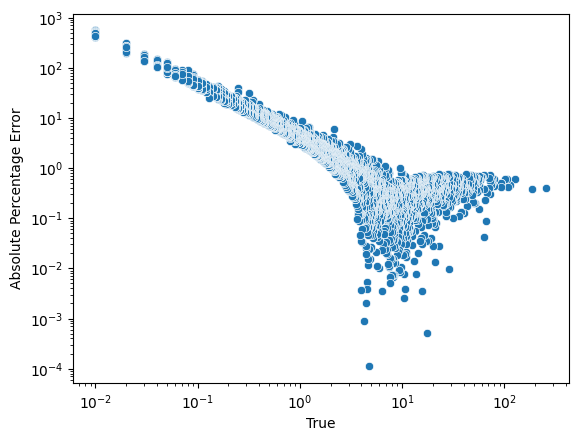

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 5: Bidirectional LSTM

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6))))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='03_Hyperparameter_Tuning/lstm_04_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('04_Models/lstm_04_best_model.h5')

Trial 10 Complete [00h 08m 29s]
val_loss: 4.028409360519921e-05

Best val_loss So Far: 1.812646587495692e-05
Total elapsed time: 01h 23m 15s
118/118 [==============================] - 0s 3ms/step - loss: 2.2143e-05
Test loss: 2.2143380192574114e-05


In [ ]:
# Load the best model
best_model = load_model('04_Models/lstm_04_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/lstm_04_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,252.770798,257.059998,4.289200,0.016686
2716,189.463516,185.600006,3.863510,0.020816
2434,123.070892,128.350006,5.279114,0.041131
1234,112.325996,114.000000,1.674004,0.014684
2795,112.880981,109.610001,3.270981,0.029842


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,0.117754,0.01,0.107754,10.775371
1462,0.441976,0.01,0.431976,43.197590
1315,-0.308386,0.01,0.318386,31.838596
1571,-0.404669,0.01,0.414669,41.466915
1404,-0.351632,0.01,0.361632,36.163246


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 1.31


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 1.89 %


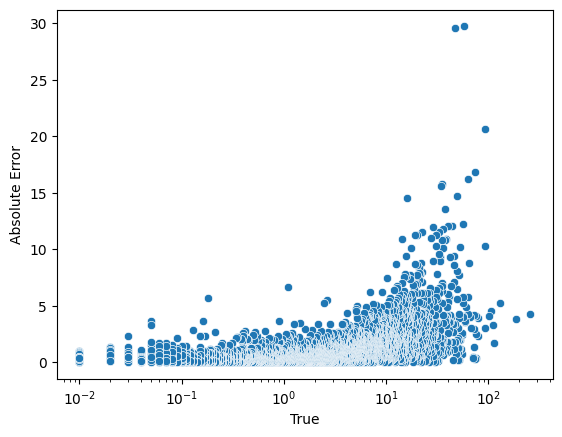

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

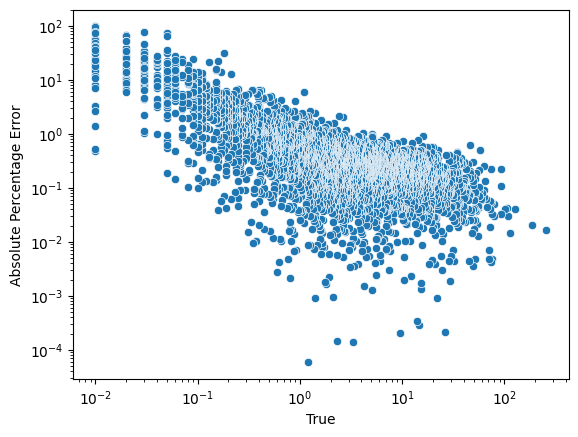

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 6: Gated Recurrent Unit

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='03_Hyperparameter_Tuning/GRU_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('04_Models/GRU_best_model.h5')

Trial 10 Complete [00h 05m 37s]
val_loss: 1.804970149047828e-05

Best val_loss So Far: 1.5343208967048366e-05
Total elapsed time: 00h 55m 53s
118/118 [==============================] - 0s 2ms/step - loss: 1.3577e-05
Test loss: 1.3576974197349045e-05


In [ ]:
# Load the best model
best_model = load_model('04_Models/GRU_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/GRU_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,247.223450,257.059998,9.836548,0.038266
2716,181.191406,185.600006,4.408600,0.023753
2434,135.676514,128.350006,7.326508,0.057082
1234,117.404907,114.000000,3.404907,0.029868
2795,106.789627,109.610001,2.820374,0.025731


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,-0.400352,0.01,0.410352,41.035172
1462,0.114876,0.01,0.104876,10.487589
1315,-0.655528,0.01,0.665528,66.552818
1571,-0.447714,0.01,0.457714,45.771420
1404,-0.600539,0.01,0.610539,61.053944


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 1.12


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 2.14 %


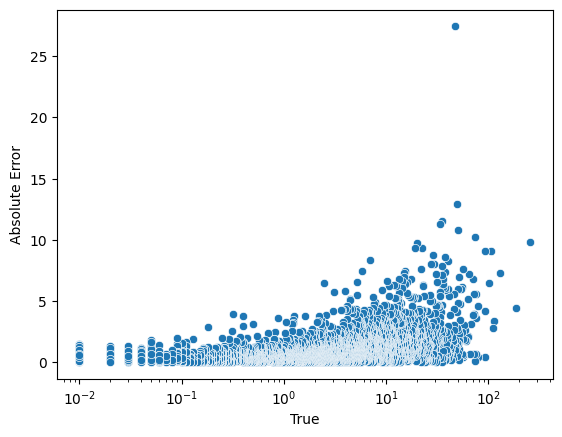

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

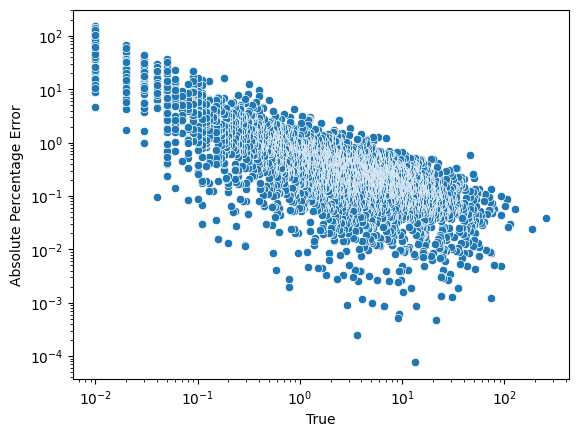

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Additional Data Preparation for Decision Trees

In [11]:
# Drop 'impliedVolatility' Column
scaled_df = scaled_df.drop(columns=['impliedVolatility'])

In [12]:
# Split Into Feature and Target Datasets
X = scaled_df.drop(columns=['Close'])
y = scaled_df['Close']

# Split the data into Training, Validation, and Test Sets
X_train, X_val, X_test = X[:int(0.98 * len(X))], X[int(0.98 * len(X)):int(0.99 * len(X))], X[int(0.99 * len(X)):]
y_train, y_val, y_test = y[:int(0.98 * len(y))], y[int(0.98 * len(y)):int(0.99 * len(y))], y[int(0.99 * len(y)):]

## Model 7: Decision Tree

In [57]:
# Define the hyperparameters for GridSearchCV
param_grid = {'max_depth': [3, 5, 7, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5]}

# Initialize a Decision Tree Regressor model
regressor = DecisionTreeRegressor()

# Perform Grid Search on the Decision Tree Regressor
grid = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Get the best hyperparameters from Grid Search
best_depth = grid.best_estimator_.get_params()['max_depth']
best_min_samples_split = grid.best_estimator_.get_params()['min_samples_split']
best_min_samples_leaf = grid.best_estimator_.get_params()['min_samples_leaf']

# Train the best Decision Tree Regressor model on the full training data
best_model = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=best_min_samples_split,
                                   min_samples_leaf=best_min_samples_leaf)
best_model.fit(X_train, y_train)

# Get the predictions on the validation set
val_predictions = best_model.predict(X_val)

# Print relevant metrics
print("Validation Mean Absolute Error: ", mean_absolute_error(y_val, val_predictions))
print("Validation Mean Squared Error: ", mean_squared_error(y_val, val_predictions))

# Save the best model using joblib
joblib.dump(best_model, "04_Models/DecisionTree_best_model.joblib")

Validation Mean Absolute Error:  0.008697203094632608
Validation Mean Squared Error:  0.00026663511195039024


['04_Models/DecisionTree_best_model.joblib']

In [58]:
# Load the Best Model
best_model = joblib.load('04_Models/DecisionTree_best_model.joblib')

# Make Predictions on the Test Set
y_pred = best_model.predict(X_test)

# Create a DataFrame of the Predictions and True Values side by side
results = pd.DataFrame(list(zip(y_pred, y_test)), columns=['Predicted', 'True'])
# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
# Create a Column for the Absolute Error
results['Absolute Error'] = abs(results['Predicted'] - results['True'])
# Create a Column for the Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Absolute Error'] / results['True'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/DecisionTree_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

,Predicted,True,Absolute Error,Absolute Percentage Error
2541,17.857369,257.059998,239.202629,0.930532
2716,178.099998,185.600006,7.500008,0.040410
2434,113.755306,128.350006,14.594700,0.113710
1234,34.369584,114.000000,79.630416,0.698512
2795,108.653750,109.610001,0.956251,0.008724


In [59]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,3.864670,0.01,3.854670,385.466991
1462,0.918903,0.01,0.908903,90.890300
1315,5.029446,0.01,5.019446,501.944625
1571,0.045306,0.01,0.035306,3.530612
1404,2.868976,0.01,2.858976,285.897588


In [60]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 4.01


In [61]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 9.64 %


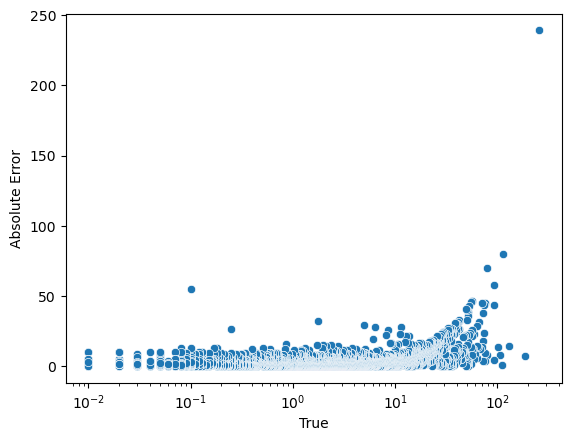

In [62]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

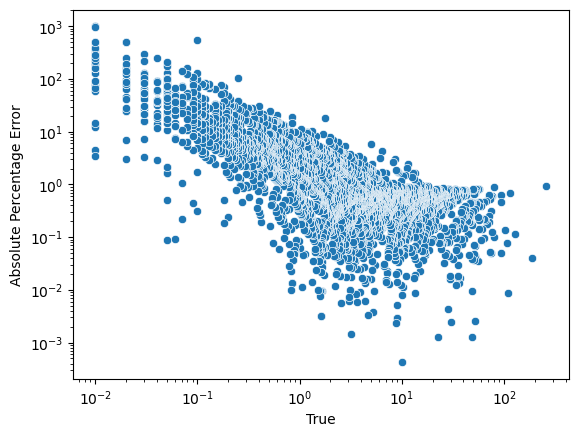

In [63]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 8: XGBoost

In [13]:
from dask_saturn import SaturnCluster
from dask.distributed import Client
import dask.dataframe as dd

import xgboost as xgb

client = Client(SaturnCluster())

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
INFO:dask-saturn:Success!


In [14]:
# Convert the Training, Validation, and Test Sets to Dask DataFrames
X_train = dd.from_pandas(X_train, npartitions=4)
X_val = dd.from_pandas(X_val, npartitions=4)
X_test = dd.from_pandas(X_test, npartitions=4)

y_train = dd.from_pandas(y_train, npartitions=4)
y_val = dd.from_pandas(y_val, npartitions=4)
y_test = dd.from_pandas(y_test, npartitions=4)

In [15]:
# Create dask DMatrix objects for training and validation data
dtrain = xgb.dask.DaskDMatrix(client=client, data=X_train, label=y_train)
dvalid = xgb.dask.DaskDMatrix(client=client, data=X_val, label=y_val)

# Define hyperparameters to try
learning_rates = [0.01, 0.1, 0.2]
max_depths = [3, 5, 7]
n_estimators = [100, 200, 300]

# Initialize variables to store the best model and its MSE
best_model = None
best_mse = float('inf')

# Perform manual hyperparameter tuning
for lr in learning_rates:
    for md in max_depths:
        for n_est in n_estimators:
            result = xgb.dask.train(
                client=client,
                params={
                    "objective": "reg:squarederror",
                    "tree_method": "hist",
                    "learning_rate": lr,
                    "max_depth": md,
                    "n_estimators": n_est,
                },
                dtrain=dtrain,
                num_boost_round=500,
                evals=[(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=10,
            )

            # Use the model for prediction
            model = result["booster"]
            y_pred = xgb.dask.predict(client, model, X_val)

            # Compute and print the MSE
            mse = mean_squared_error(y_val.compute(), y_pred.compute())

            print(f"Learning rate: {lr}, Max depth: {md}, N_estimators: {n_est}, MSE: {mse}")

            # Update the best model and its MSE
            if mse < best_mse:
                best_model = model
                best_mse = mse

# Print the best MSE
print("Best Mean Squared Error:", round(best_mse, 6))

# Use the best model for prediction on the test set
y_pred_test = xgb.dask.predict(client, best_model, X_test)

# Print test set MSE
mse_test = mean_squared_error(y_test.compute(), y_pred_test.compute())
print("Test Mean Squared Error:", round(mse_test, 6))

# Save the Model
joblib.dump(best_model, "04_Models/XGBoost_best_model.joblib")

Learning rate: 0.01, Max depth: 3, N_estimators: 100, MSE: 0.00044133505051141737
Learning rate: 0.01, Max depth: 3, N_estimators: 200, MSE: 0.00044133505051141737
Learning rate: 0.01, Max depth: 3, N_estimators: 300, MSE: 0.00044133505051141737
Learning rate: 0.01, Max depth: 5, N_estimators: 100, MSE: 0.0002311139929258321
Learning rate: 0.01, Max depth: 5, N_estimators: 200, MSE: 0.0002311139929258321
Learning rate: 0.01, Max depth: 5, N_estimators: 300, MSE: 0.0002311139929258321
Learning rate: 0.01, Max depth: 7, N_estimators: 100, MSE: 0.00010558997917257941
Learning rate: 0.01, Max depth: 7, N_estimators: 200, MSE: 0.00010558997917257941
Learning rate: 0.01, Max depth: 7, N_estimators: 300, MSE: 0.00010558997917257941
Learning rate: 0.1, Max depth: 3, N_estimators: 100, MSE: 0.0001238236817966518
Learning rate: 0.1, Max depth: 3, N_estimators: 200, MSE: 0.0001238236817966518
Learning rate: 0.1, Max depth: 3, N_estimators: 300, MSE: 0.0001238236817966518
Learning rate: 0.1, Max d

['04_Models/XGBoost_best_model.joblib']

In [22]:
# Load the Best Model
best_model = joblib.load('04_Models/XGBoost_best_model.joblib')

# Make Predictions on the Test Set
y_pred = xgb.dask.predict(client, best_model, X_test)

# Create a DataFrame of the Predictions and True Values side by side
results = pd.DataFrame(list(zip(y_pred, y_test)), columns=['Predicted', 'True'])
# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
# Create a Column for the Absolute Error
results['Absolute Error'] = abs(results['Predicted'] - results['True'])
# Create a Column for the Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Absolute Error'] / results['True'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results/XGBoost_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

,Predicted,True,Absolute Error,Absolute Percentage Error
2541,366.630574,257.059998,109.570577,0.426245
2716,178.979972,185.600006,6.620034,0.035668
2434,128.951542,128.350006,0.601536,0.004687
1234,127.037616,114.000000,13.037616,0.114365
2795,119.999720,109.610001,10.389719,0.094788


In [24]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,-0.577188,0.01,0.587188,58.718843
1462,-0.187148,0.01,0.197148,19.714846
1315,0.270629,0.01,0.260629,26.062883
1571,-0.967815,0.01,0.977815,97.781509
1404,-0.252789,0.01,0.262789,26.278873


In [25]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 0.85


In [26]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 1.36 %


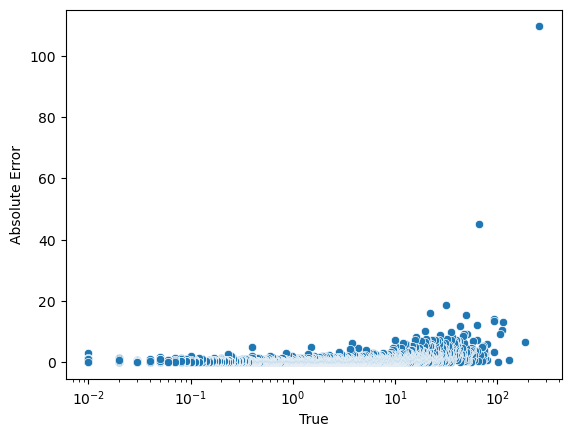

In [27]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

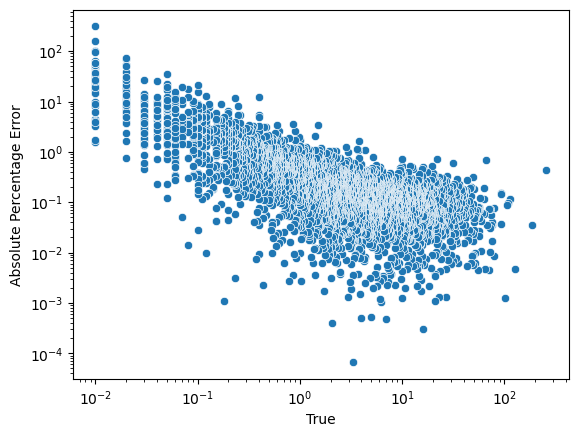

In [28]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Load Additional Data for Binomial Option Pricing Models

In [350]:
# Read in Parquet File Again
df_final = pd.read_parquet('02_Clean_Data/df_final.parquet')
# Shuffle Rows of Data
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)
# Recreate Splits
# Split Into Feature and Target Datasets
X = df_final.drop(columns=['Close'])
y = df_final['Close']
# Split the data into Training, Validation, and Test Sets
X_train, X_val, X_test = X[:int(0.98 * len(X))], X[int(0.98 * len(X)):int(0.99 * len(X))], X[int(0.99 * len(X)):]
y_train, y_val, y_test = y[:int(0.98 * len(y))], y[int(0.98 * len(y)):int(0.99 * len(y))], y[int(0.99 * len(y)):]
# Create a Column for Expiration Date
X_test['Expiration Date'] = X_test['Days to Expiration'].apply(lambda x: pd.to_datetime(X_test['Date'].iloc[0])
                                                                  + timedelta(days=x))
# Reorder Columns
X_test = X_test[['ID', 'Date', 'Ticker', 'Call', 'Stock Ticker', 'Expiration Date',
                    'Days to Expiration',
       'strike', 'impliedVolatility', 'Price-0', 'Price-4', 'Price-5',
       'Price-6', 'Price-7', 'Price-10', 'Price-11', 'Price-12', 'Price-13',
       'Price-14', 'Price-17', 'Price-18', 'Price-19', 'Price-20', 'Price-21',
       'Price-24', 'Price-25', 'Price-26', 'Price-27', 'Price-28', 'rate-0']]

In [351]:
# Filter all the columns that start with 'Price-'
price_columns = [col for col in X_test.columns if col.startswith('Price-')]
price_test = X_test[price_columns]
# Make a Column with Each Rows Standard Deviation
X_test['Historical Volatility'] = price_test.std(axis=1)

In [352]:
# Drop all Columns that start with 'Price-' except for 'Price-0' and 'rate-0'
X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith('Price-') and col != 'Price-0'])
# Rename the 'Call' Column to 'Option Type'
X_test = X_test.rename(columns={'Call': 'Option Type'})
# Convert the 'Option Type' Column to 'call' or 'put' strings
X_test['Option Type'] = X_test['Option Type'].apply(lambda x: 'call' if x == 1 else 'put')
X_test.head()

,ID,Date,Ticker,Option Type,Stock Ticker,Expiration Date,Days to Expiration,strike,impliedVolatility,Price-0,rate-0,Historical Volatility
371588,WSM-2023-03-01,2023-03-01,WSM230421C00135000,call,WSM,2023-04-21,51,135.0,0.513677,123.510002,3.994,6.630304
371589,WHR-2023-04-12,2023-04-12,WHR230421P00135000,put,WHR,2023-03-10,9,135.0,0.271492,133.949997,3.421,2.080089
371590,IEF-2023-03-21,2023-03-21,IEF230421C00101000,call,IEF,2023-04-01,31,101.0,0.113290,97.806213,3.606,1.515693
371591,AMAT-2022-11-09,2022-11-09,AMAT230421P00097500,put,AMAT,2023-08-11,163,97.5,0.531255,93.930771,4.151,6.403194
371592,RTX-2023-04-13,2023-04-13,RTX230421P00101000,put,RTX,2023-03-09,8,101.0,0.173348,101.680000,3.452,1.538101


In [353]:
# Load the CSV file with Dividends Data and Dates
dividend_data = pd.read_csv('01_Raw_Data\dividend_data.csv')
# Convert the Dataframe back to a List of Dictionaries
dividend_data = dividend_data.to_dict('records')

In [354]:
# Load the CSV file
dividend_data = pd.read_csv('01_Raw_Data/dividend_data.csv')
# Convert the Dataframe back to a List of Dictionaries
dividend_data = dividend_data.to_dict('records')

In [355]:
# Convert 'ticker' values to the dictionary keys
dividend_data = {d['ticker']: d for d in dividend_data}
# Remove the 'ticker' field from the dictionary
for d in dividend_data.values():
    del d['ticker']

In [356]:
# Preview an Item
dividend_data['AAPL']

{'dividend_dates': "['1987-05-11', '1987-08-10', '1987-11-17', '1988-02-12', '1988-05-16', '1988-08-15', '1988-11-21', '1989-02-17', '1989-05-22', '1989-08-21', '1989-11-17', '1990-02-16', '1990-05-21', '1990-08-20', '1990-11-16', '1991-02-15', '1991-05-20', '1991-08-19', '1991-11-18', '1992-02-14', '1992-06-01', '1992-08-17', '1992-11-30', '1993-02-12', '1993-05-28', '1993-08-16', '1993-11-19', '1994-02-07', '1994-05-27', '1994-08-15', '1994-11-18', '1995-02-13', '1995-05-26', '1995-08-16', '1995-11-21', '2012-08-09', '2012-11-07', '2013-02-07', '2013-05-09', '2013-08-08', '2013-11-06', '2014-02-06', '2014-05-08', '2014-08-07', '2014-11-06', '2015-02-05', '2015-05-07', '2015-08-06', '2015-11-05', '2016-02-04', '2016-05-05', '2016-08-04', '2016-11-03', '2017-02-09', '2017-05-11', '2017-08-10', '2017-11-10', '2018-02-09', '2018-05-11', '2018-08-10', '2018-11-08', '2019-02-08', '2019-05-10', '2019-08-09', '2019-11-07', '2020-02-07', '2020-05-08', '2020-08-07', '2020-11-06', '2021-02-05',

In [357]:
# Create a Column with the 'dividend_dates' from 'dividend_data' dictionary
X_test['Dividend Dates'] = X_test['Stock Ticker'].apply(lambda x: dividend_data[x]['dividend_dates'])
# Create a Column with the 'dividend_payments' from 'dividend_data' dictionary
X_test['Dividend Payments'] = X_test['Stock Ticker'].apply(lambda x: dividend_data[x]['dividend_payments'])

## Model 9: Binomial Option Pricing Model

In [358]:
import numpy as np
import pandas as pd
from datetime import datetime
import ast

def binomial_option_price(S, K, r, T, sigma, t, n, option_type, div_input, div_dates_input, date_input, exp_date, total):
    
    # Reformat Dividend Dates and Payments
    dates = ast.literal_eval(div_dates_input)
    payments = ast.literal_eval(div_input)
    # Create New Pandas DataFrame with the Dividend Dates and Payments
    df_dividends = pd.DataFrame(list(zip(dates, payments)), columns=['Date', 'Payment'])
    # Convert the 'Date' Column to a Datetime Object
    df_dividends['Date'] = pd.to_datetime(df_dividends['Date'])
    # Filter the Dividend Dates and Payments that on of after 'Date' and before 'Expiration Date'
    df_dividends = df_dividends[(df_dividends['Date'] >= date_input) & (df_dividends['Date'] <= exp_date)]
    # Convert Each Column to a list
    dates = df_dividends['Date'].tolist()
    # Convert dates to strings
    dates = [d.strftime('%Y-%m-%d') for d in dates]
    div = df_dividends['Payment'].tolist()
    # Convert the dividend payment dates to time-to-dividend format
    div_dates = []
    for div_date_str in dates:
        div_date = datetime.strptime(div_date_str, '%Y-%m-%d')
        time_to_div = (div_date - datetime.now()).days / 365.25
        div_dates.append(time_to_div)

    if len(div) == 0:
        div = None
        div_dates = None

    # Initialize Parameters
    delta_t = T/n
    u = np.exp(sigma*np.sqrt(delta_t))
    d = 1/u
    p = (np.exp(r*delta_t) - d) / (u - d)

    # Initialize stock and option prices at expiration
    stock_price = np.zeros((n+1, n+1))
    option_price = np.zeros((n+1, n+1))
    for i in range(n+1):
        stock_price[n, i] = S * u**(n-i) * d**i
        if option_type == "call":
            option_price[n, i] = max(stock_price[n, i] - K, 0)
        elif option_type == "put":
            option_price[n, i] = max(K - stock_price[n, i], 0)

    # Calculate option price at earlier nodes using backward recursion
    for j in range(n-1, -1, -1):
        for i in range(j+1):
            stock_price[j, i] = S * u**(j-i) * d**i
            
            # Adjust stock price for dividends
            if div_dates is not None and div is not None:
                for k in range(len(div)):
                    if t + j * delta_t == div_dates[k]:
                        stock_price[j, i] -= div[k]

            if option_type == "call":
                exercise_value = max(stock_price[j, i] - K, 0)
            elif option_type == "put":
                exercise_value = max(K - stock_price[j, i], 0)

            continuation_value = np.exp(-r * delta_t) * (p * option_price[j + 1, i] + (1 - p) * option_price[j + 1, i + 1])

            # Compare the exercise value with the continuation value and select the maximum
            option_price[j, i] = max(exercise_value, continuation_value)

    # Increase global count
    global count

    count += 1
    if count % 500 == 0:
        print(f'Count: {count} of {total}')
    # Return option price at time 0
    return option_price[0, 0]



In [359]:
# Create a Column in the DataFrame for the Option Price using the Binomial Option Pricing Model
count = 0
X_test['Binomial Option Price'] = X_test.apply(lambda x: binomial_option_price(x['Price-0'], x['strike'],            
                                                                                x['rate-0']/100, x['Days to Expiration'],
                                                                                x['Historical Volatility'], 0, 100,
                                                                                x['Option Type'], x['Dividend Payments'],
                                                                                x['Dividend Dates'], x['Date'],
                                                                                x['Expiration Date'], len(X_test['Price-0'])),
                                                                                axis=1)

Count: 500 of 3754
Count: 1000 of 3754
Count: 1500 of 3754
Count: 2000 of 3754
Count: 2500 of 3754
Count: 3000 of 3754
Count: 3500 of 3754


In [360]:
# Create a Column for Absolute Error
X_test['Absolute Error'] = abs(X_test['Binomial Option Price'] - y_test)

# Create a Column for Absolute Percentage Error
X_test['Absolute Percentage Error'] = abs(X_test['Binomial Option Price'] - y_test) / y_test

# Combine all Columns Together
X_test = pd.concat([X_test, y_test], axis=1)

# Create results dataframe
results = X_test[['Binomial Option Price', 'Close', 'Absolute Error', 'Absolute Percentage Error']]

# Rename Columns
results = results.rename(columns={'Binomial Option Price': 'Predicted', 'Close': 'True'})

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('05_Testing_Results\Binomial_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

,Predicted,True,Absolute Error,Absolute Percentage Error
374129,668.185087,257.059998,411.125090,1.599335
374304,447.685285,185.600006,262.085279,1.412097
374022,inf,128.350006,inf,inf
372822,inf,114.000000,inf,inf
374383,424.386761,109.610001,314.776760,2.871789


In [361]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
373328,57.520539,0.01,57.510539,5751.054071
373050,93.199997,0.01,93.189997,9318.999903
372903,251.509995,0.01,251.499995,25150.000013
373159,21.087253,0.01,21.077253,2107.725331
372992,39.268269,0.01,39.258269,3925.826973


In [362]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: inf


In [363]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: inf %


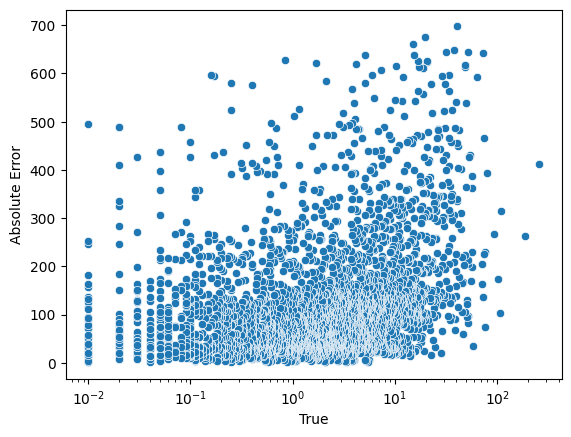

In [364]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

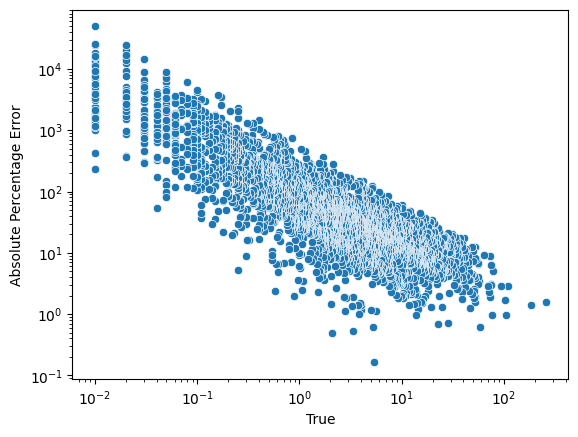

In [365]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')